 # Instructions #

- "maptype" is '7.7', 'CO', 'Ha', or '21'. more can be added but fits files are unpacked differently
- "imgtype" is 'original', 'normalized', 'dog', or 'mask'
- "projection" is 'sky' or 'polar'

 to run the analysis for a new galaxy:
 1. create an instance of Galaxy()
 2. fetch the predicted scale data from mega tables using Galaxy.getscales(filepath)
 3. input observation data from fits file using Galaxy.readdata(filepath, maptype)
 4. fetch the galaxy geometry from sample tables using Galaxy.setgeometry(id, filepath)
 5. run the image processing with Galaxy.picture_prop(Rmax, ...)
    - you will have to try different Rmax values for each galaxy, it is the maximum radius to which the image is deprojected
    - try and see whether tlog = True or False preserves more detail. check the results with Galaxy.show(maptype, 'original', 'sky') and Galaxy.show(maptype, 'normalized', 'sky')
    - tlog = True works better for galaxies with bright bulges while False works better for more uniform brightness.
 6. run the measurement with Galaxy.auto_scales(maptype)

 different maps can be cross-correlated. just input more observation data, run the processing and then Galaxy.auto_scales(maptype1, maptype2)
 correlation can be 'linear' (an elementwise product of the image with the offset image)
 or 'spearman'. the latter is much slower, produces a smoother signal and usually gives less self-consistent results. default is 'linear'.
 images can be offset radially when correltating and can produce 2D signals. this is not used in the default measurement method.

 the find_peaks parameters can also be changed. change peak_height to set the minimum height. (the range is 0-1)

 to verify results visually, use Galaxy.plot_peaks_subplots(maptype) to see every correlation signal.
 in my experience when measurements are inconsistent (with predictions and/or themselves) the peaks in the correspoonding signals are usually very small.

 the image processing is saved at different stages:
 1. a log normalization is applied which can be toggled with tlog=False. saved as 'normalized'.
 2. a difference of gaussians algorithm is applied. saved as 'dog'
    the values of the two parameters, dog_sigma1 and dog_sigma2 can be changed to pick out different size features.
 3. a threshold is applied using a hyperbolic tangent function. saved as 'mask'
    the threshold value and slope, mask_thres and mask_grad can be changed but generally don't need to be.
 each of these is deprojected into polar coordinates. 'original' is not deprojected.
 the measurement can be ran with any of these images by changing the imgtype parameter. default is 'mask'

note to self: difference of gaussians acts as a band pass filter for different scale lengths. it might not be useful at all since it will always introduce a bias towards the scales that get through the band pass filter.

running the analysis with just the 'normalized' images should pick out the most dominant scale?
I've disabled all image processing including tlog (deprojection is still needed, obviously)

In [52]:
import coord_transform as tr
import scale_model as scales

import astropy.units as u
import astropy.coordinates as c
from astropy.wcs import WCS
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
from astropy.table import Table

import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as scimg
import scipy.signal as signal
from scipy.stats import spearmanr

In [53]:
class Images():

    # the Galaxy contains this class
    # this class contains Maps which are sets of images of a certain wavelength
    # each Map contains differently processed and projected images

    def __init__(self):

        self.mapnames = np.array([])
        self.maps = []


    def createmap(self, _type):

        self.mapnames = np.append(self.mapnames, _type)
        self.maps.append(Map())


    def getmap(self, _type):
        
        i = np.where(self.mapnames == _type)[0][0]

        if i == -1:
            raise ValueError('invalid map type '+str(_type))

        return self.maps[i]


class Map():

    def __init__(self):

        self.original = None
        self.wcs = None

        self.normalized_sky = None
        self.dog_sky = None
        self.mask_sky = None

        self.normalized_pol = None
        self.dog_pol = None
        self.mask_pol = None

    def getimage(self, imgtype, projection):

        # this is a silly function
        if projection == 'sky':
            if imgtype == 'original':
                image = self.original
            elif imgtype == 'normalized':
                image = self.normalized_sky
            elif imgtype == 'dog':
                image = self.dog_sky
            elif imgtype == 'mask':
                image = self.mask_sky
            else:
                print('invalid image type')
                return
        elif projection == 'polar':
            if imgtype == 'normalized':
                image = self.normalized_pol
            elif imgtype == 'dog':
                image = self.dog_pol
            elif imgtype == 'mask':
                image = self.mask_pol
            else:
                print('invalid image type')
                return
        else:
            print("invalid projection type")
            return
        
        return image
        

    def size(self):

        if self.original is None:
            return 0

        size = np.sqrt(self.original.shape[0]*self.original.shape[1]).astype(int)

        return size

In [54]:
class Galaxy():
    
    # list of fields #

    #dog_sigma1
    #dog_sigma2
    #mask_thres
    #mask_grad
    #peak_dist
    #peak_height
    #stepsize

    #name
    #Images
    #Scales
    #Geometry

    #slices
    #resolution
    #R
    #phi
    #R_log

    #Rmax
    #bound_rad
    #rollangles
    #roll_R


    def __init__(self, ID):

        # ID is the galaxy name that will be displayed on plots

        self.name = ID
        self.Images = Images()
        self.Scales = scales.Scales_Model()
        self.Geometry = tr.GalaxyGeometry()
        
        self.peak_prop()

        return
    

    def getscales(self, filepath):

        # calculates predicted scales from mega table

        self.Scales.inst(self.name, filepath)

        return
    
    
    def readdata(self, filepath, maptype):

        # inputs a map from a fits file

        if maptype == '7.7':
            filename = get_pkg_data_filename(filepath)
            hdu = fits.open(filename)[0]
        elif maptype == 'CO':
            filename = get_pkg_data_filename(filepath)
            hdu = fits.open(filename)[0]
        elif maptype == 'Ha':
            hdulist = fits.open(filepath)
            hdu = hdulist['HA6562_FLUX']
        elif maptype == '21':
            filename = get_pkg_data_filename(filepath)
            hdu = fits.open(filename)[1]
        else:
            print("couldn't read data")
            return
        
        data = np.array(hdu.data, dtype=np.float64)
        wcs = WCS(hdu.header)

        np.nan_to_num(data, copy=False)

        self.Images.createmap(maptype)

        self.Images.getmap(maptype).original = data
        self.Images.getmap(maptype).wcs = wcs

        return
    

    def setgeometry(self, row_name, filepath):

        # sets the galaxy geometry for polar deprojection

        table = Table.read(filepath)

        RA = table[table['name']==row_name]['orient_ra'].value
        Dec = table[table['name']==row_name]['orient_dec'].value
        incl = table[table['name']==row_name]['orient_incl'].value
        PA = table[table['name']==row_name]['orient_posang'].value
        dist = table[table['name']==row_name]['dist'].value * 1000

        self.Geometry.setpar(RA, Dec, incl, PA, dist)

        return
    

    def resolution(self, maptype):

        # calculates pc/px resolution

        map = self.Images.getmap(maptype)

        sky1 = map.wcs.pixel_to_world(0,0)
        sky2 = map.wcs.pixel_to_world(0,1)

        angle = np.abs(sky2.dec.radian - sky1.dec.radian)

        resolution = (angle*self.Geometry.dist)[0]*1000

        return resolution
    

    def picture_prop(self, Rmax, tlog=True, sig_resol=360, sigma1=10, sigma2=20):

        # sets parameters
        
        # radius to which polar image is filled
        self.Rmax = Rmax

        # number of radial bins of polar image
        self.slices = int(Rmax*10)

        # radial boundaries of slices
        self.bound_rad = np.linspace(0, self.Rmax, self.slices+1)

        # number of steps in the correlation
        self.stepsize = sig_resol
        self.rollangles = (2*np.pi)/self.stepsize*np.arange(self.stepsize)

        Rshift = Rmax/self.slices*2
        self.roll_R = np.linspace(0, Rshift, self.stepsize)

        # set the polar image resolution based on the map with the highest resolution
        sizes = np.empty(self.Images.mapnames.size)
        i=0
        for map in self.Images.mapnames:
            size = self.Images.getmap(map).size()
            sizes[i] = size
            i+=1
        self.imgshape = int(np.max(sizes))
        print("shape: "+str(self.imgshape)+"x"+str(self.imgshape))

        self.R, self.phi = np.meshgrid(np.linspace(0, self.Rmax, self.imgshape), np.linspace(0, (2*np.pi), self.imgshape, endpoint=0))
        self.R_log = np.log10(self.R.clip(1, None))

        for map in self.Images.mapnames:
            if self.Images.getmap(map).original is not None:
                self.process(map, sigma1, sigma2, tlog)
                self.unwind(map)

        return


    def process(self, maptype, sigma1, sigma2, tlog=False):

        # applies log normalization, difference of gaussians, arctan mask
        # saves everything along the way

        mask_grad = 10
        mask_thres = 0.2

        processed = self.Images.getmap(maptype).original.copy()

        if tlog:

            processed.clip(1e-7, None, processed)
            processed = np.log(processed)

        processed.clip(0, None, processed)

        self.Images.getmap(maptype).normalized_sky = processed.copy()

        gauss1 = scimg.gaussian_filter(processed, sigma1)
        gauss2 = scimg.gaussian_filter(processed, sigma2)
        processed = gauss1 - gauss2

        self.Images.getmap(maptype).dog_sky = processed.copy()

        #mask_thres = processed.mean()+processed.std()

        processed = (1+np.tanh(mask_grad*(processed-mask_thres)))/2

        self.Images.getmap(maptype).mask_sky = processed

        return


    def deproject(self, data, wcs):

        # deprojects an image from sky to galactic polar coordinates

        skymap = tr.cartesian(self.Geometry, [self.R, (self.phi*180/np.pi)*u.deg])
        pixels = wcs.world_to_pixel(c.SkyCoord(skymap[0].value, skymap[1].value, unit='deg'))
        polar_image = scimg.map_coordinates(data.transpose(), pixels, order=3)

        return polar_image

    
    def unwind(self, maptype):
        
        # deprojects each image of a map

        map = self.Images.getmap(maptype)

        norm = self.deproject(map.normalized_sky, map.wcs)
        map.normalized_pol = norm
        dog = self.deproject(map.dog_sky, map.wcs)
        map.dog_pol = dog
        mask = self.deproject(map.mask_sky, map.wcs)
        map.mask_pol = mask

        return
    

    def show(self, maptype, imgtype, projection, save=False):

        # shows an image in sky coordinates

        map = self.Images.getmap(maptype)
        wcs = map.wcs
        image = map.getimage(imgtype, projection)

        v_max = image.mean()+3*image.std()

        if projection == 'sky':
            plt.figure()
            plt.subplot(projection=wcs)
            plt.title(self.name)
            plt.imshow(image, vmin=0, vmax=v_max, cmap='inferno')
            if imgtype == 'original':
                plt.colorbar(label='MJy/sr')
            else:
                plt.colorbar(label='Rescaled flux')
            plt.xlabel('RA')
            plt.ylabel('Dec')
            if save:
                plt.savefig(self.name+'_'+maptype+'_'+imgtype+'_sky.svg', format='svg')
        
        elif projection == 'polar':
            lines = np.log10(self.bound_rad[1:])[np.where(self.bound_rad >= 1)[0]-1]
            plt.figure()
            plt.title(self.name)
            plt.pcolormesh(self.phi, self.R_log, image, vmin=0, vmax=v_max, cmap='inferno')
            plt.colorbar(label='Rescaled flux')
            plt.errorbar(np.ones(lines.size)*np.pi, lines, xerr=np.pi, yerr=None, fmt='.', markersize=0.1, c='w', lw=0.5, alpha=0.5)
            plt.xlim(xmax=2*np.pi)
            plt.xlabel('Polar angle (rad)')
            plt.ylabel('log R (kpc)')
            if save:
                plt.savefig(self.name+'_'+maptype+'_'+imgtype+'_polar.svg', format='svg')

        return
    

    def take_slice(self, layer, maptype, imgtype):

        # returns the slice of a polar image with index 'layer'
        # layer index starts from 1

        map = self.Images.getmap(maptype)
        image = map.getimage(imgtype, "polar")

        R_low = self.bound_rad[layer-1]
        R_high = self.bound_rad[layer]

        i_low = np.floor(R_low/self.Rmax*image.shape[1]).astype(int)
        i_high = np.ceil(R_high/self.Rmax*image.shape[1]).astype(int)
        image_slice = image[:,i_low:i_high]

        return image_slice, [i_low, i_high]
    

    def sliceshow(self, layer, maptype, imgtype, asp):

        # shows the slice of the polar image

        image_slice, rad_slice = self.take_slice(layer, maptype, imgtype)

        aspect = asp

        v_max = image_slice.mean()+3*image_slice.std()

        title_str = 'Slice ' + str(layer) + ' out of ' + str(self.slices) + '\nR = ' + np.round(self.bound_rad[layer-1], 3).astype(str) + ' to ' + np.round(self.bound_rad[layer], 3).astype(str) + ' pc'

        plt.figure()
        fig, ax = plt.subplots()
        ax.set_aspect(aspect)
        plt.imshow(np.transpose(image_slice), vmin=0, vmax=v_max, cmap='inferno') #self.phi[:,0], rad_slice, 
        plt.colorbar(location='bottom')
        plt.xlabel('Polar angle (rad)')
        plt.ylabel('log Galactic radius (kpc)')
        plt.title(title_str)

        return


    def correlate(self, layer, maptype1, maptype2=None, imgtype='mask', dR=0, method='linear'):

        # returns a 1D correlation signal for the slice 'layer' between map1 and map2
        # with a radial offset dR

        if maptype2 is None:
            maptype2 = maptype1
        
        polar_image = self.Images.getmap(maptype2).getimage(imgtype, 'polar')
        
        image_slice, ind = self.take_slice(layer, maptype1, imgtype)
        i_dR = np.floor(dR/self.Rmax*polar_image.shape[1]).astype(int)
        image_rshift = np.roll(polar_image, -i_dR, 1)[:,ind[0]:ind[1]]

        indices = np.ceil((np.arange(self.stepsize)/self.stepsize)*image_slice.shape[0]).astype(int)
        signl = np.zeros(self.stepsize)

        if method == 'linear':
            for i in range(self.stepsize):
                image_shift = np.roll(image_rshift, indices[i], 0)
                avg = np.multiply(image_slice, image_shift).mean()
                signl[i] = avg
            signl /= (image_slice**2).mean()
        
        elif method == 'spearman':
            for i in range(self.stepsize):
                image_shift = np.roll(image_rshift, indices[i], 0)
                avg, p_ = spearmanr(image_slice, image_shift, axis=None)
                signl[i] = avg
        
        else:
            raise ValueError('invalid correlation method')
    
        return signl
    

    def rad_shift(self, layer, maptype1, maptype2=None, imgtype='mask', method='linear'):

        # returns a 2D correlation signal as a function of angular and radial offset
        
        signals = np.zeros((self.stepsize,self.stepsize))
        for i in range(self.stepsize):
            signl = self.correlate(layer, maptype1, maptype2, imgtype, self.roll_R[i], method)
            signals[i,:] = signl

        return signals
    

    def plot_fullsignal(self, layer, maptype1, maptype2=None, method='linear'):

        # plots the 2D correlation signal of a slice

        signals = self.rad_shift(layer, maptype1, maptype2, method)

        plt.figure()
        plt.pcolormesh(self.rollangles, self.roll_R, signals, cmap='plasma')
        plt.colorbar(label='Correlation strength')
        plt.xlabel('angular offset (rad)')
        plt.ylabel('radial offset (kpc)')
        plt.title('Corrrelation signal (slice '+str(layer)+' out of '+str(self.slices)+')' + '\nR = ' + self.bound_rad[layer-1].round(3).astype(str) + ' to ' + self.bound_rad[layer].round(3).astype(str) + ' kpc')

        return


    def plot_signals_subplots(self, map1, map2=None, method='linear'):

        # plots the 2D correlation signal of every slice in one figure

        num_rows = int(np.ceil(np.sqrt(self.slices)))
        num_cols = int(np.ceil(self.slices / num_rows))
        
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
        fig.suptitle(self.name + ' Signals Subplots')

        for layer, ax in enumerate(axes.flat):

            if layer >= self.slices:
                
                ax.axis('off')
                continue
            
            signals = self.rad_shift(layer+1, map1, map2, method)
            rollangle = self.rollangles
            roll_R = self.roll_R

            ax.pcolormesh(rollangle, roll_R, signals, cmap='plasma')
            ax.set_title('Slice {}'.format(layer+1), fontsize=10)
            ax.tick_params(axis='both', which='both', labelsize=5)
        
        plt.tight_layout()
        plt.show()

        return


    ###### peaks ######

    def peak_prop(self, dist=1, height=0.05):

        # changes find_peak parameters on runtime

        self.peak_dist = dist
        self.peak_height = height

        return
    

    def signal_peaks(self, signl):

        # finds peaks in a 1D signal

        peaks, _ = signal.find_peaks(signl, distance=self.peak_dist, height=self.peak_height)

        peak_values = signl[peaks]
        peak_phi = self.rollangles[peaks]

        return peak_values, peak_phi
    

    def plot_signalpeaks(self, layer, dR, maptype1, maptype2=None, imgtype='mask', method='linear'):

        # plots the 1D signal and peaks of a radial slice with a radial offset

        signl = self.correlate(layer, maptype1, maptype2, imgtype, dR, method)
        
        peak_values, peak_phi = self.signal_peaks(signl)

        slice_str = 'R = ' + str(round(self.bound_rad[layer-1], 2)) + ' to ' + str(round(self.bound_rad[layer], 2)) + ', radial offset = ' + str(dR)

        plt.figure()
        fig, ax = plt.subplots()
        plt.scatter(peak_phi, peak_values, c='r', s=15)
        plt.plot(self.rollangles, signl, c='b')
        if method == 'linear':

            ax.set_ylim(ymin=-0.05, ymax=1.05)
        elif method == 'spearman':
                
            ax.set_ylim(ymin=-1.05, ymax=1.05)
        plt.title(slice_str)
        plt.xlabel('angular offset (rad)')
        plt.ylabel('linear correlation')

        return

    
    def plot_peaks_subplots(self, maptype1, maptype2=None, imgtype='mask', method='linear'):

        # plots all 1D signals with 0 radial offset in one figure

        num_rows = int(np.ceil(np.sqrt(self.slices)))
        num_cols = int(np.ceil(self.slices / num_rows))
        
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
        fig.suptitle(self.name + ' Signals Subplots')

        for layer, ax in enumerate(axes.flat):

            if layer >= self.slices:

                ax.axis('off')
                continue
            
            signl = self.correlate(layer, maptype1, maptype2, imgtype, 0, method)
            
            rollangle = self.rollangles

            peak_values, peak_phi = self.signal_peaks(signl)

            ax.plot(rollangle, signl)
            ax.scatter(peak_phi, peak_values, c='r', s=10)
            ax.set_title('Slice {}'.format(layer+1), fontsize=10)# + '\nR = ' + np.round(self.bound_rad[layer], 3).astype(str) + ' to ' + np.round(self.bound_rad[layer+1], 3).astype(str) + ' kpc', fontsize=10)
            if method == 'linear':

                ax.set_ylim(ymin=-0.05, ymax=1.05)
            elif method == 'spearman':
                
                ax.set_ylim(ymin=-1.05, ymax=1.05)
            ax.tick_params(axis='both', which='both', labelsize=5)
        
        plt.tight_layout()
        plt.show()

        return
    

    def mean_peak_separation(self, peak_phi):
        
        separation_angles = np.diff(peak_phi)

        mean_separation = np.mean(separation_angles)
        std_separation = np.std(separation_angles)/np.sqrt(len(peak_phi))

        return mean_separation, std_separation


    def measure_scales(self, maptype, maptype2=None, imgtype='mask', method='linear', grouping=5):

        # measures scales from the correlation signal
        # has some unused outdated parts
        
        feature_length = []
        feature_length_un = []
        radius = []
        for layer in range(self.slices):

            signl = self.correlate(layer, maptype, maptype2, imgtype, 0, method)

            _peak_values, peak_phi = self.signal_peaks(signl)

            if len(peak_phi) < 7:
                continue

            delta_phi, delta_phi_un = self.mean_peak_separation(peak_phi[peak_phi < np.pi/2])
                    
            feature_length.append(delta_phi*self.bound_rad[layer]*1000)
            feature_length_un.append(delta_phi_un*self.bound_rad[layer]*1000)
            radius.append(self.bound_rad[layer+1])
        
        feature_length = np.array(feature_length)
        feature_length_un = np.array(feature_length_un)
        radius = np.array(radius)

        num_groups = len(feature_length) // grouping

        feature_reshaped = feature_length[:num_groups*grouping].reshape([num_groups, grouping])
        feature_un_reshaped = feature_length_un[:num_groups*grouping].reshape([num_groups, grouping])
        radius_reshaped = radius[:num_groups*grouping].reshape([num_groups, grouping])

        measurement = feature_reshaped.mean(axis=1)

        # error of group mean
        measurement_err1 = feature_reshaped.std(axis=1)/np.sqrt(grouping)

        # add errors in group
        measurement_err2 = np.sqrt(np.sum(feature_un_reshaped**2))/grouping

        uncertainty = measurement_err1#np.sqrt(measurement_err1**2+measurement_err2**2)

        radii = radius_reshaped.mean(axis=1)

        return [feature_length, radius], feature_length_un#[measurement, radii], uncertainty


    def auto_scales(self, maptype, maptype2=None, imgtype='normalized',  method='linear', save=False):

        # plots scales measured with auto correlation

        results, uncertainty = self.measure_scales(maptype, maptype2, imgtype, method)
        self.Scales.plot_allscales(results, uncertainty, save)

        return

Set OBSGEO-B to   -37.752318 from OBSGEO-[XYZ].
Set OBSGEO-H to 1738852372.675 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


shape: 2216x2216


/tmp/ipykernel_4049/3538657962.py:323: RuntimeWarning: Mean of empty slice.
  avg = np.multiply(image_slice, image_shift).mean()
/mnt/home/zjakab/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_4049/3538657962.py:325: RuntimeWarning: Mean of empty slice.
  signl /= (image_slice**2).mean()
/mnt/home/zjakab/anaconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/home/zjakab/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/mnt/home/zjakab/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/

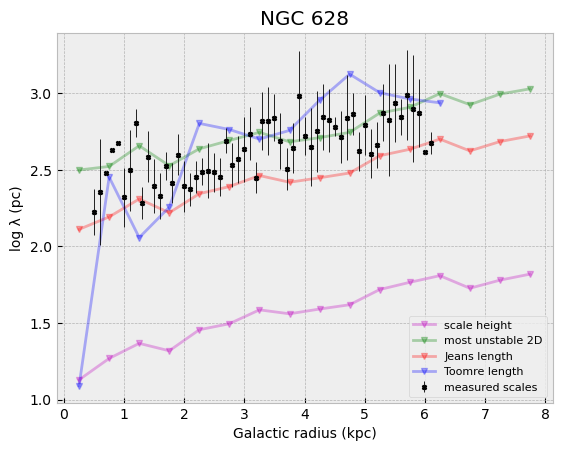

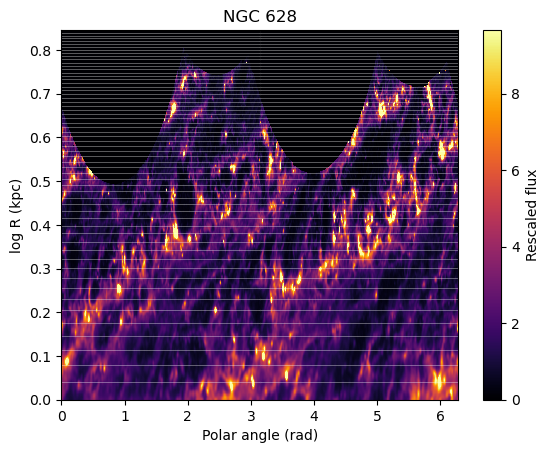

In [55]:
ngc0628 = Galaxy('NGC 628')
ngc0628.getscales('/mnt/bigdata/PHANGS/Archive/Products/mega_tables/v4p0/annulus/NGC0628_combined_annulus_0p5kpc.ecsv')
ngc0628.readdata('/mnt/space/erosolow/phangs_jwst/v0p8p1_anchored/ngc0628_F770W_atF2100W_anchored.fits', '7.7')
#ngc0628.readdata('/mnt/bigdata/PHANGS/Archive/ALMA/delivery_v4p0/ngc0628/ngc0628_12m+7m+tp_co21_broad_mom0.fits', 'CO')
#ngc0628.readdata('/mnt/bigdata/PHANGS/Archive/MUSE/DR2.2/copt/MUSEDAP/fiducial/NGC0628-0.92asec_MAPS.fits', 'Ha')
#ngc0628.readdata('/mnt/space/erosolow/phangs_jwst/v0p8p1_anchored/ngc0628_F2100W_atF2100W_anchored.fits', '21')
ngc0628.setgeometry('ngc0628', '/mnt/bigdata/PHANGS/Archive/Products/sample_tables/phangs_sample_table_v1p6.fits')
ngc0628.picture_prop(7, tlog=False)
ngc0628.auto_scales('7.7')
ngc0628.show('7.7', 'normalized', 'polar')

/mnt/home/zjakab/project/scale_model.py:64: RuntimeWarning: divide by zero encountered in divide
  lamb2d = (2*self.vdisp[valid_i]**2)/(s.G.value*self.sigma[valid_i])
/mnt/home/zjakab/project/scale_model.py:81: RuntimeWarning: divide by zero encountered in divide
  jean = (self.vdisp[valid_i]*np.pi**(1/2))/(s.G.value*self.rho)**(1/2)
Set OBSGEO-B to    19.723355 from OBSGEO-[XYZ].
Set OBSGEO-H to 1564151617.100 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


shape: 1961x1961


/tmp/ipykernel_4049/3538657962.py:323: RuntimeWarning: Mean of empty slice.
  avg = np.multiply(image_slice, image_shift).mean()
/mnt/home/zjakab/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_4049/3538657962.py:325: RuntimeWarning: Mean of empty slice.
  signl /= (image_slice**2).mean()
/mnt/home/zjakab/anaconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/home/zjakab/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/mnt/home/zjakab/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/

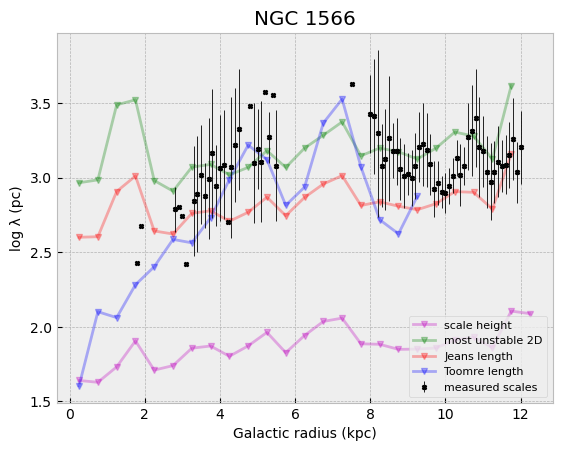

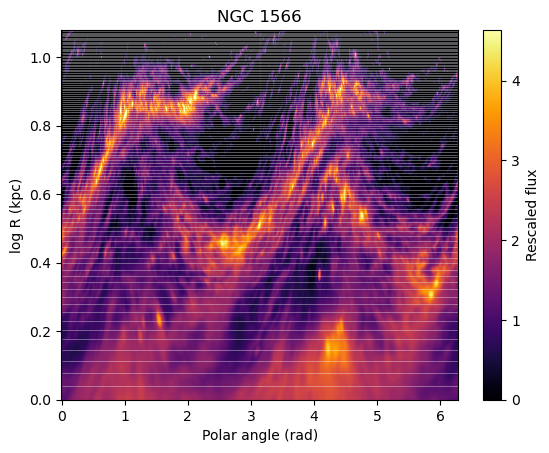

In [56]:
ngc1566 = Galaxy('NGC 1566')
ngc1566.getscales('/mnt/bigdata/PHANGS/Archive/Products/mega_tables/v4p0/annulus/NGC1566_combined_annulus_0p5kpc.ecsv')
ngc1566.readdata('/mnt/space/erosolow/phangs_jwst/v0p8p1_anchored/ngc1566_F770W_atF2100W_anchored.fits', '7.7')
#ngc1566.readdata('/mnt/bigdata/PHANGS/Archive/ALMA/delivery_v4p0/ngc1566/ngc1566_12m+7m+tp_co21_broad_mom0.fits', 'CO')
#ngc1566.readdata('/mnt/bigdata/PHANGS/Archive/MUSE/DR2.2/copt/MUSEDAP/fiducial/NGC1566-0.80asec_MAPS.fits', 'Ha')
#ngc1566.readdata('/mnt/space/erosolow/phangs_jwst/v0p8p1_anchored/ngc1566_F2100W_atF2100W_anchored.fits', '21')
ngc1566.setgeometry('ngc1566', '/mnt/bigdata/PHANGS/Archive/Products/sample_tables/phangs_sample_table_v1p6.fits')
ngc1566.picture_prop(12)
ngc1566.auto_scales('7.7')
ngc1566.show('7.7', 'normalized', 'polar')

Set OBSGEO-B to     9.610127 from OBSGEO-[XYZ].
Set OBSGEO-H to 1660590830.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


shape: 1818x1818


/tmp/ipykernel_4049/3538657962.py:323: RuntimeWarning: Mean of empty slice.
  avg = np.multiply(image_slice, image_shift).mean()
/mnt/home/zjakab/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_4049/3538657962.py:325: RuntimeWarning: Mean of empty slice.
  signl /= (image_slice**2).mean()
/mnt/home/zjakab/anaconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/home/zjakab/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/mnt/home/zjakab/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/

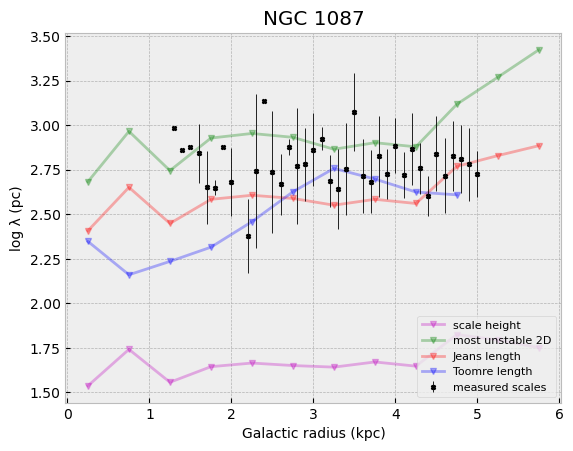

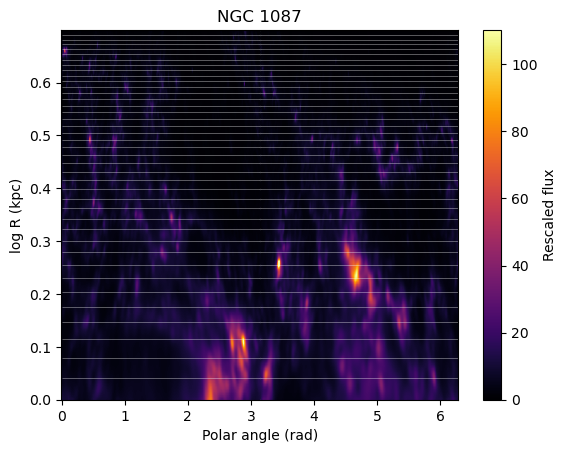

In [57]:
ngc1087 = Galaxy('NGC 1087')
ngc1087.getscales('/mnt/bigdata/PHANGS/Archive/Products/mega_tables/v4p0/annulus/NGC1087_combined_annulus_0p5kpc.ecsv')
ngc1087.readdata('/mnt/space/erosolow/phangs_jwst/v0p8p1_anchored/ngc1087_F770W_atF2100W_anchored.fits', '7.7')
#ngc1087.readdata('/mnt/bigdata/PHANGS/Archive/ALMA/delivery_v4p0/ngc1087/ngc1087_12m+7m+tp_co21_broad_mom0.fits', 'CO')
#ngc1087.readdata('/mnt/bigdata/PHANGS/Archive/MUSE/DR2.2/copt/MUSEDAP/fiducial/NGC1087-0.92asec_MAPS.fits', 'Ha')
#ngc1087.readdata('/mnt/space/erosolow/phangs_jwst/v0p8p1_anchored/ngc1087_F2100W_atF2100W_anchored.fits', '21')
ngc1087.setgeometry('ngc1087', '/mnt/bigdata/PHANGS/Archive/Products/sample_tables/phangs_sample_table_v1p6.fits')
ngc1087.picture_prop(5, tlog=False)
ngc1087.auto_scales('7.7')
ngc1087.show('7.7', 'normalized', 'polar')

Set OBSGEO-B to   -29.512030 from OBSGEO-[XYZ].
Set OBSGEO-H to 1646609408.623 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


shape: 2052x2052


/tmp/ipykernel_4049/3538657962.py:323: RuntimeWarning: Mean of empty slice.
  avg = np.multiply(image_slice, image_shift).mean()
/mnt/home/zjakab/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_4049/3538657962.py:325: RuntimeWarning: Mean of empty slice.
  signl /= (image_slice**2).mean()
/mnt/home/zjakab/anaconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/home/zjakab/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/mnt/home/zjakab/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/

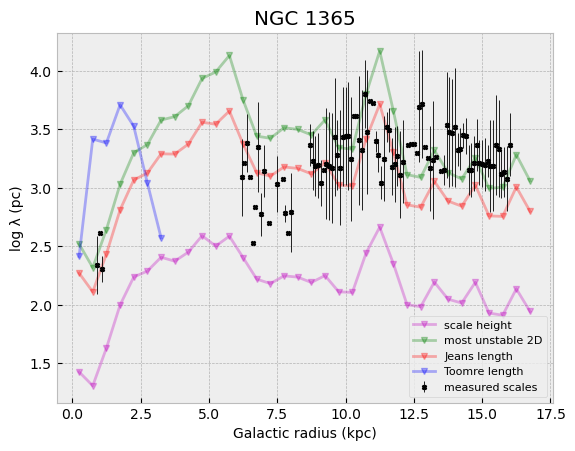

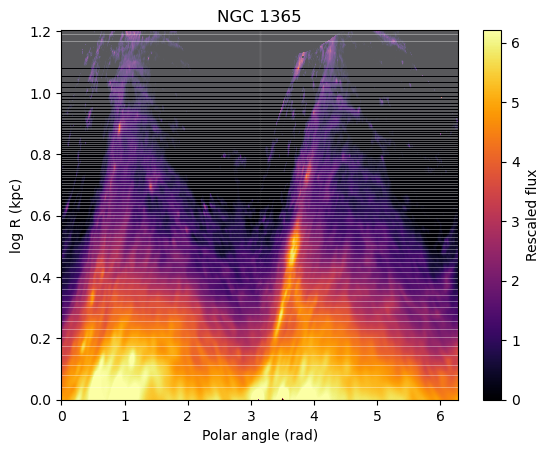

In [58]:
ngc1365 = Galaxy('NGC 1365')
ngc1365.getscales('/mnt/bigdata/PHANGS/Archive/Products/mega_tables/v4p0/annulus/NGC1365_combined_annulus_0p5kpc.ecsv')
ngc1365.readdata('/mnt/space/erosolow/phangs_jwst/v0p8p1_anchored/ngc1365_F770W_atF2100W_anchored.fits', '7.7')
#ngc1365.readdata('/mnt/bigdata/PHANGS/Archive/ALMA/delivery_v4p0/ngc1365/ngc1365_12m+7m+tp_co21_broad_mom0.fits', 'CO')
#ngc1365.readdata('/mnt/bigdata/PHANGS/Archive/MUSE/DR2.2/copt/MUSEDAP/fiducial/NGC1365-1.15asec_MAPS.fits', 'Ha')
#ngc1365.readdata('/mnt/space/erosolow/phangs_jwst/v0p8p1_anchored/ngc1365_F2100W_atF2100W_anchored.fits', '21')
ngc1365.setgeometry('ngc1365', '/mnt/bigdata/PHANGS/Archive/Products/sample_tables/phangs_sample_table_v1p6.fits')
ngc1365.picture_prop(16)
ngc1365.auto_scales('7.7')
ngc1365.show('7.7', 'normalized', 'polar')

Set OBSGEO-B to    13.499292 from OBSGEO-[XYZ].
Set OBSGEO-H to 1596339492.990 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


shape: 1959x1959


/tmp/ipykernel_4049/3538657962.py:323: RuntimeWarning: Mean of empty slice.
  avg = np.multiply(image_slice, image_shift).mean()
/mnt/home/zjakab/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_4049/3538657962.py:325: RuntimeWarning: Mean of empty slice.
  signl /= (image_slice**2).mean()
/mnt/home/zjakab/anaconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/home/zjakab/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/mnt/home/zjakab/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/

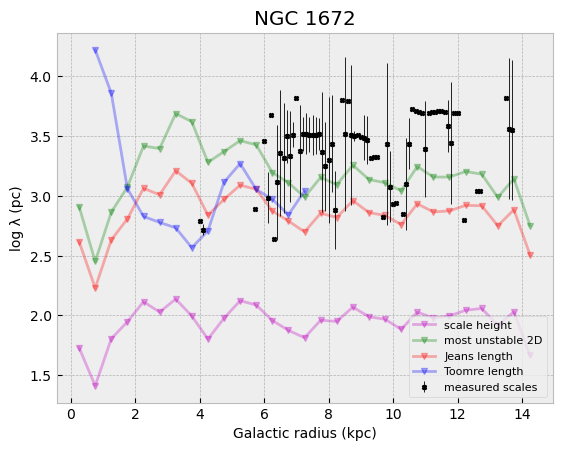

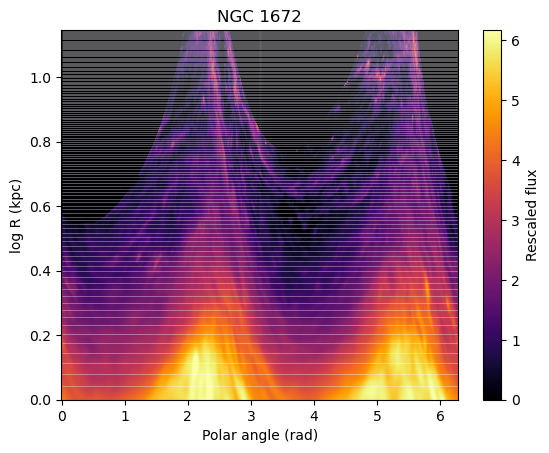

In [59]:
ngc1672 = Galaxy('NGC 1672')
ngc1672.getscales('/mnt/bigdata/PHANGS/Archive/Products/mega_tables/v4p0/annulus/NGC1672_combined_annulus_0p5kpc.ecsv')
ngc1672.readdata('/mnt/space/erosolow/phangs_jwst/v0p8p1_anchored/ngc1672_F770W_atF2100W_anchored.fits', '7.7')
#ngc1672.readdata('/mnt/bigdata/PHANGS/Archive/ALMA/delivery_v4p0/ngc1672/ngc1672_12m+7m+tp_co21_broad_mom0.fits', 'CO')
#ngc1672.readdata('/mnt/bigdata/PHANGS/Archive/MUSE/DR2.2/copt/MUSEDAP/fiducial/NGC1672-0.96asec_MAPS.fits', 'Ha')
#ngc1672.readdata('/mnt/space/erosolow/phangs_jwst/v0p8p1_anchored/ngc1672_F2100W_atF2100W_anchored.fits', '21')
ngc1672.setgeometry('ngc1672', '/mnt/bigdata/PHANGS/Archive/Products/sample_tables/phangs_sample_table_v1p6.fits')
ngc1672.picture_prop(14)
ngc1672.auto_scales('7.7')
ngc1672.show('7.7', 'normalized', 'polar')

/mnt/home/zjakab/project/scale_model.py:64: RuntimeWarning: divide by zero encountered in divide
  lamb2d = (2*self.vdisp[valid_i]**2)/(s.G.value*self.sigma[valid_i])
/mnt/home/zjakab/project/scale_model.py:81: RuntimeWarning: divide by zero encountered in divide
  jean = (self.vdisp[valid_i]*np.pi**(1/2))/(s.G.value*self.rho)**(1/2)
Set OBSGEO-B to   -20.146580 from OBSGEO-[XYZ].
Set OBSGEO-H to 1513709250.683 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


shape: 1810x1810


/tmp/ipykernel_4049/3538657962.py:323: RuntimeWarning: Mean of empty slice.
  avg = np.multiply(image_slice, image_shift).mean()
/mnt/home/zjakab/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_4049/3538657962.py:325: RuntimeWarning: Mean of empty slice.
  signl /= (image_slice**2).mean()


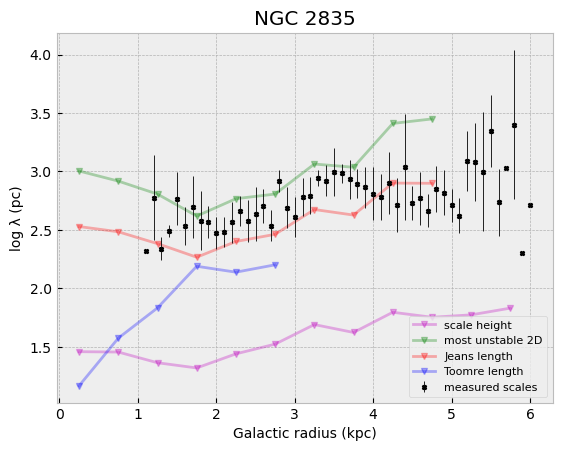

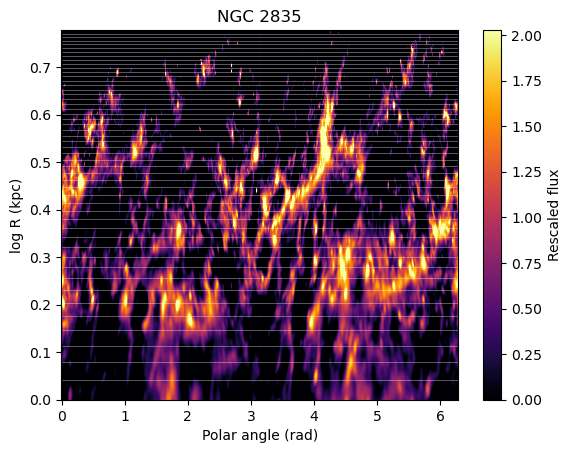

In [60]:
ngc2835 = Galaxy('NGC 2835')
ngc2835.getscales('/mnt/bigdata/PHANGS/Archive/Products/mega_tables/v4p0/annulus/NGC2835_combined_annulus_0p5kpc.ecsv')
ngc2835.readdata('/mnt/space/erosolow/phangs_jwst/v0p8p1_anchored/ngc2835_F770W_atF2100W_anchored.fits', '7.7')
#ngc2835.readdata('/mnt/bigdata/PHANGS/Archive/ALMA/delivery_v4p0/ngc2835/ngc2835_12m+7m+tp_co21_broad_mom0.fits', 'CO')
#ngc2835.readdata('/mnt/bigdata/PHANGS/Archive/MUSE/DR2.2/copt/MUSEDAP/fiducial/NGC2835-1.15asec_MAPS.fits', 'Ha')
#ngc2835.readdata('/mnt/space/erosolow/phangs_jwst/v0p8p1_anchored/ngc2835_F2100W_atF2100W_anchored.fits', '21')
ngc2835.setgeometry('ngc2835', '/mnt/bigdata/PHANGS/Archive/Products/sample_tables/phangs_sample_table_v1p6.fits')
ngc2835.picture_prop(6)
ngc2835.auto_scales('7.7')
ngc2835.show('7.7', 'normalized', 'polar')

Set OBSGEO-B to     7.733920 from OBSGEO-[XYZ].
Set OBSGEO-H to 1686937977.879 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


shape: 2292x2292


/tmp/ipykernel_4049/3538657962.py:323: RuntimeWarning: Mean of empty slice.
  avg = np.multiply(image_slice, image_shift).mean()
/mnt/home/zjakab/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_4049/3538657962.py:325: RuntimeWarning: Mean of empty slice.
  signl /= (image_slice**2).mean()
/mnt/home/zjakab/anaconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/home/zjakab/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/mnt/home/zjakab/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/

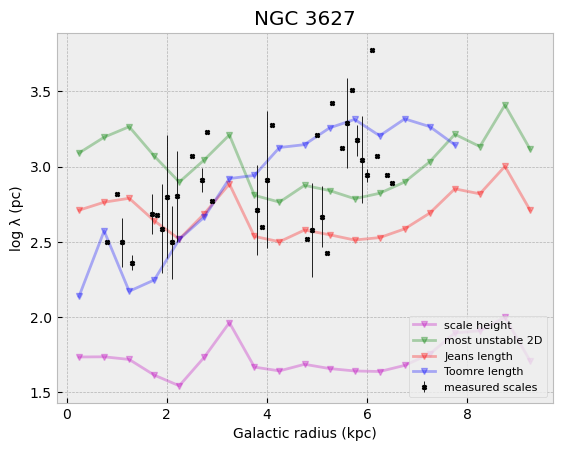

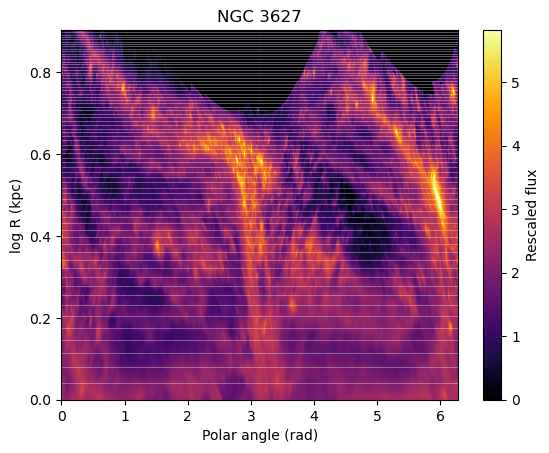

In [61]:
ngc3627 = Galaxy('NGC 3627')
ngc3627.getscales('/mnt/bigdata/PHANGS/Archive/Products/mega_tables/v4p0/annulus/NGC3627_combined_annulus_0p5kpc.ecsv')
ngc3627.readdata('/mnt/space/erosolow/phangs_jwst/v0p8p1_anchored/ngc3627_F770W_atF2100W_anchored.fits', '7.7')
#ngc3627.readdata('/mnt/bigdata/PHANGS/Archive/ALMA/delivery_v4p0/ngc3627/ngc3627_12m+7m+tp_co21_broad_mom0.fits', 'CO')
#ngc3627.readdata('/mnt/bigdata/PHANGS/Archive/MUSE/DR2.2/copt/MUSEDAP/fiducial/NGC3627-1.05asec_MAPS.fits', 'Ha')
#ngc3627.readdata('/mnt/space/erosolow/phangs_jwst/v0p8p1_anchored/ngc3627_F2100W_atF2100W_anchored.fits', '21')
ngc3627.setgeometry('ngc3627', '/mnt/bigdata/PHANGS/Archive/Products/sample_tables/phangs_sample_table_v1p6.fits')
ngc3627.picture_prop(8)
ngc3627.auto_scales('7.7')
ngc3627.show('7.7', 'normalized', 'polar')

Set OBSGEO-B to   -36.640463 from OBSGEO-[XYZ].
Set OBSGEO-H to 1725520403.108 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


shape: 2397x2397


/tmp/ipykernel_4049/3538657962.py:323: RuntimeWarning: Mean of empty slice.
  avg = np.multiply(image_slice, image_shift).mean()
/mnt/home/zjakab/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_4049/3538657962.py:325: RuntimeWarning: Mean of empty slice.
  signl /= (image_slice**2).mean()


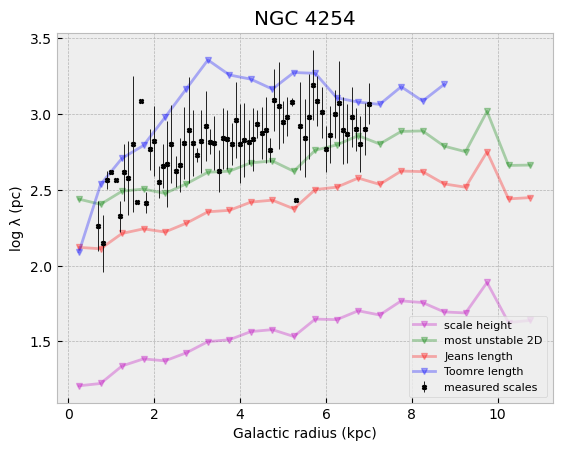

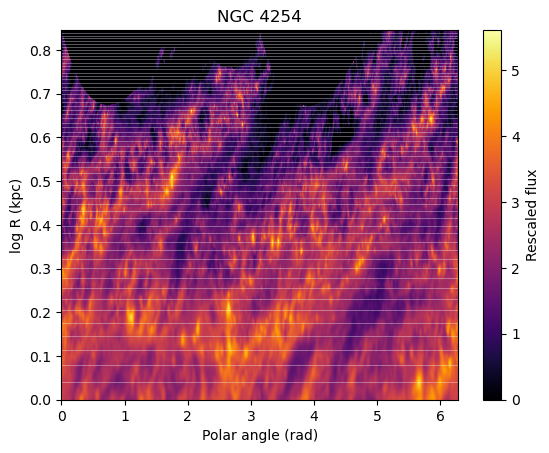

In [62]:
ngc4254 = Galaxy('NGC 4254')
ngc4254.getscales('/mnt/bigdata/PHANGS/Archive/Products/mega_tables/v4p0/annulus/NGC4254_combined_annulus_0p5kpc.ecsv')
ngc4254.readdata('/mnt/space/erosolow/phangs_jwst/v0p8p1_anchored/ngc4254_F770W_atF2100W_anchored.fits', '7.7')
#ngc4254.readdata('/mnt/bigdata/PHANGS/Archive/ALMA/delivery_v4p0/ngc4254/ngc4254_12m+7m+tp_co21_broad_mom0.fits', 'CO')
#ngc4254.readdata('/mnt/bigdata/PHANGS/Archive/MUSE/DR2.2/copt/MUSEDAP/fiducial/NGC4254-0.89asec_MAPS.fits', 'Ha')
#ngc4254.readdata('/mnt/space/erosolow/phangs_jwst/v0p8p1_anchored/ngc4254_F2100W_atF2100W_anchored.fits', '21')
ngc4254.setgeometry('ngc4254', '/mnt/bigdata/PHANGS/Archive/Products/sample_tables/phangs_sample_table_v1p6.fits')
ngc4254.picture_prop(7)
ngc4254.auto_scales('7.7')
ngc4254.show('7.7', 'normalized', 'polar')

Set OBSGEO-B to    11.132347 from OBSGEO-[XYZ].
Set OBSGEO-H to 1643283650.105 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


shape: 2531x2531


/tmp/ipykernel_4049/3538657962.py:323: RuntimeWarning: Mean of empty slice.
  avg = np.multiply(image_slice, image_shift).mean()
/mnt/home/zjakab/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_4049/3538657962.py:325: RuntimeWarning: Mean of empty slice.
  signl /= (image_slice**2).mean()
/mnt/home/zjakab/anaconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/home/zjakab/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/mnt/home/zjakab/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/

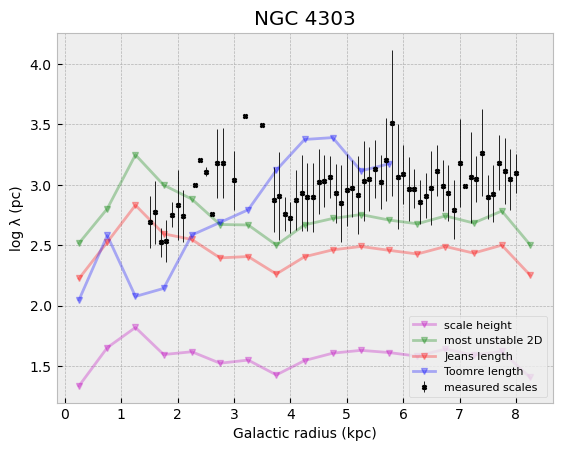

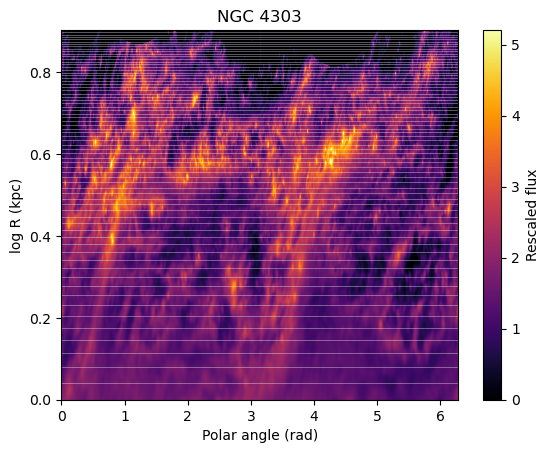

In [63]:
ngc4303 = Galaxy('NGC 4303')
ngc4303.getscales('/mnt/bigdata/PHANGS/Archive/Products/mega_tables/v4p0/annulus/NGC4303_combined_annulus_0p5kpc.ecsv')
ngc4303.readdata('/mnt/space/erosolow/phangs_jwst/v0p8p1_anchored/ngc4303_F770W_atF2100W_anchored.fits', '7.7')
#ngc4303.readdata('/mnt/bigdata/PHANGS/Archive/ALMA/delivery_v4p0/ngc4303/ngc4303_12m+7m+tp_co21_broad_mom0.fits', 'CO')
#ngc4303.readdata('/mnt/bigdata/PHANGS/Archive/MUSE/DR2.2/copt/MUSEDAP/fiducial/NGC4303-0.78asec_MAPS.fits', 'Ha')
#ngc4303.readdata('/mnt/space/erosolow/phangs_jwst/v0p8p1_anchored/ngc4303_F2100W_atF2100W_anchored.fits', '21')
ngc4303.setgeometry('ngc4303', '/mnt/bigdata/PHANGS/Archive/Products/sample_tables/phangs_sample_table_v1p6.fits')
ngc4303.picture_prop(8)
ngc4303.auto_scales('7.7')
ngc4303.show('7.7', 'normalized', 'polar')

Set OBSGEO-B to     8.121260 from OBSGEO-[XYZ].
Set OBSGEO-H to 1678394468.558 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


shape: 2467x2467


/tmp/ipykernel_4049/3538657962.py:323: RuntimeWarning: Mean of empty slice.
  avg = np.multiply(image_slice, image_shift).mean()
/mnt/home/zjakab/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_4049/3538657962.py:325: RuntimeWarning: Mean of empty slice.
  signl /= (image_slice**2).mean()
/mnt/home/zjakab/anaconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/home/zjakab/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/mnt/home/zjakab/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/

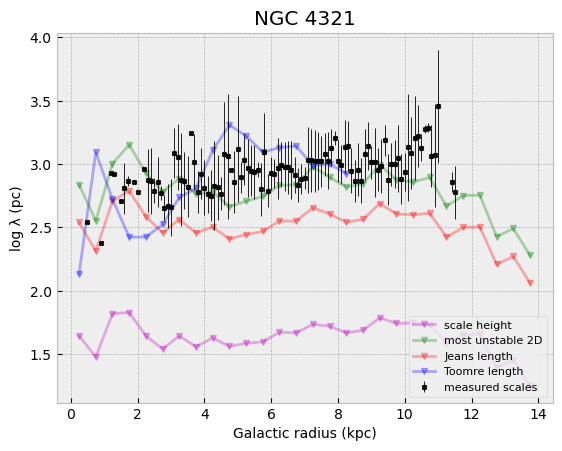

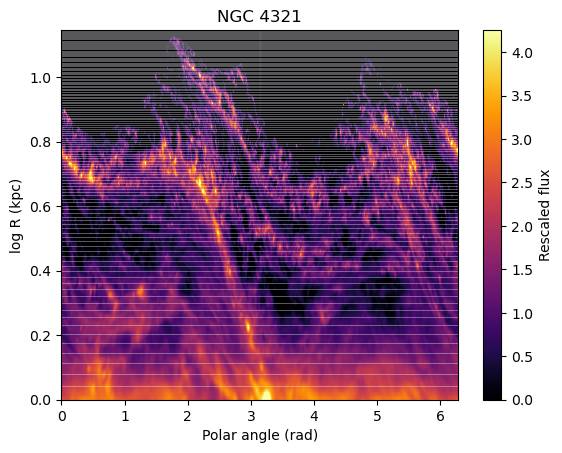

In [64]:
ngc4321 = Galaxy('NGC 4321')
ngc4321.getscales('/mnt/bigdata/PHANGS/Archive/Products/mega_tables/v4p0/annulus/NGC4321_combined_annulus_0p5kpc.ecsv')
ngc4321.readdata('/mnt/space/erosolow/phangs_jwst/v0p8p1_anchored/ngc4321_F770W_atF2100W_anchored.fits', '7.7')
#ngc4321.readdata('/mnt/bigdata/PHANGS/Archive/ALMA/delivery_v4p0/ngc4321/ngc4321_12m+7m+tp_co21_broad_mom0.fits', 'CO')
#ngc4321.readdata('/mnt/bigdata/PHANGS/Archive/MUSE/DR2.2/copt/MUSEDAP/fiducial/NGC4321-1.16asec_MAPS.fits', 'Ha')
#ngc4321.readdata('/mnt/space/erosolow/phangs_jwst/v0p8p1_anchored/ngc4321_F2100W_atF2100W_anchored.fits', '21')
ngc4321.setgeometry('ngc4321', '/mnt/bigdata/PHANGS/Archive/Products/sample_tables/phangs_sample_table_v1p6.fits')
ngc4321.picture_prop(14)
ngc4321.auto_scales('7.7')
ngc4321.show('7.7', 'normalized', 'polar')

Set OBSGEO-B to    13.255929 from OBSGEO-[XYZ].
Set OBSGEO-H to 1602222013.027 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


shape: 1860x1860


/tmp/ipykernel_4049/3538657962.py:323: RuntimeWarning: Mean of empty slice.
  avg = np.multiply(image_slice, image_shift).mean()
/mnt/home/zjakab/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_4049/3538657962.py:325: RuntimeWarning: Mean of empty slice.
  signl /= (image_slice**2).mean()
/mnt/home/zjakab/anaconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/home/zjakab/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/mnt/home/zjakab/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/

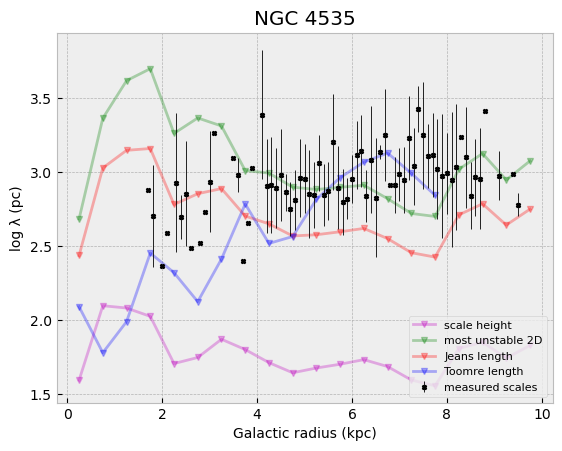

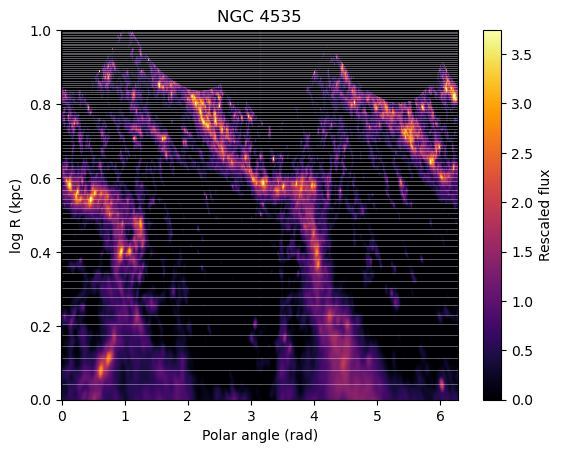

In [65]:
ngc4535 = Galaxy('NGC 4535')
ngc4535.getscales('/mnt/bigdata/PHANGS/Archive/Products/mega_tables/v4p0/annulus/NGC4535_combined_annulus_0p5kpc.ecsv')
ngc4535.readdata('/mnt/space/erosolow/phangs_jwst/v0p8p1_anchored/ngc4535_F770W_atF2100W_anchored.fits', '7.7')
#ngc4535.readdata('/mnt/bigdata/PHANGS/Archive/ALMA/delivery_v4p0/ngc4535/ngc4535_12m+7m+tp_co21_broad_mom0.fits', 'CO')
#ngc4535.readdata('/mnt/bigdata/PHANGS/Archive/MUSE/DR2.2/copt/MUSEDAP/fiducial/NGC4535-0.56asec_MAPS.fits', 'Ha')
#ngc4535.readdata('/mnt/space/erosolow/phangs_jwst/v0p8p1_anchored/ngc4535_F2100W_atF2100W_anchored.fits', '21')
ngc4535.setgeometry('ngc4535', '/mnt/bigdata/PHANGS/Archive/Products/sample_tables/phangs_sample_table_v1p6.fits')
ngc4535.picture_prop(10)
ngc4535.auto_scales('7.7')
ngc4535.show('7.7', 'normalized', 'polar')

Set OBSGEO-B to   -38.353373 from OBSGEO-[XYZ].
Set OBSGEO-H to 1740828954.544 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


shape: 1599x1599


/tmp/ipykernel_4049/3538657962.py:323: RuntimeWarning: Mean of empty slice.
  avg = np.multiply(image_slice, image_shift).mean()
/mnt/home/zjakab/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_4049/3538657962.py:325: RuntimeWarning: Mean of empty slice.
  signl /= (image_slice**2).mean()
/mnt/home/zjakab/anaconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/home/zjakab/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/mnt/home/zjakab/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/

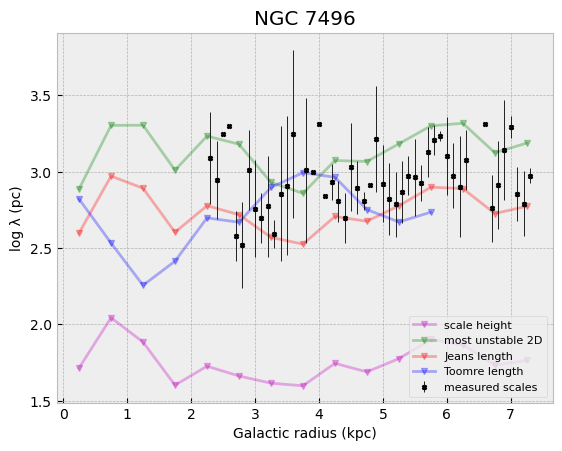

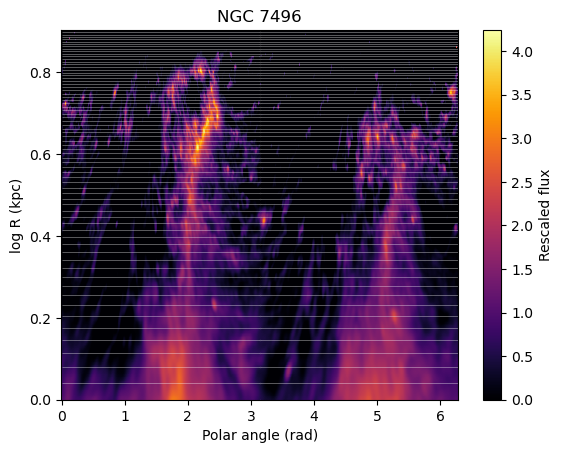

In [66]:
ngc7496 = Galaxy('NGC 7496')
ngc7496.getscales('/mnt/bigdata/PHANGS/Archive/Products/mega_tables/v4p0/annulus/NGC7496_combined_annulus_0p5kpc.ecsv')
ngc7496.readdata('/mnt/space/erosolow/phangs_jwst/v0p8p1_anchored/ngc7496_F770W_atF2100W_anchored.fits', '7.7')
#ngc7496.readdata('/mnt/bigdata/PHANGS/Archive/ALMA/delivery_v4p0/ngc7496/ngc7496_12m+7m+tp_co21_broad_mom0.fits', 'CO')
#ngc7496.readdata('/mnt/bigdata/PHANGS/Archive/MUSE/DR2.2/copt/MUSEDAP/fiducial/NGC7496-0.89asec_MAPS.fits', 'Ha')
#ngc7496.readdata('/mnt/space/erosolow/phangs_jwst/v0p8p1_anchored/ngc7496_F2100W_atF2100W_anchored.fits', '21')
ngc7496.setgeometry('ngc7496', '/mnt/bigdata/PHANGS/Archive/Products/sample_tables/phangs_sample_table_v1p6.fits')
ngc7496.picture_prop(8)
ngc7496.auto_scales('7.7')
ngc7496.show('7.7', 'normalized', 'polar')

Set OBSGEO-B to    19.241856 from OBSGEO-[XYZ].
Set OBSGEO-H to 1431127570.261 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


shape: 2701x2701


/tmp/ipykernel_4049/3538657962.py:323: RuntimeWarning: Mean of empty slice.
  avg = np.multiply(image_slice, image_shift).mean()
/mnt/home/zjakab/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_4049/3538657962.py:325: RuntimeWarning: Mean of empty slice.
  signl /= (image_slice**2).mean()
/mnt/home/zjakab/anaconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/home/zjakab/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/mnt/home/zjakab/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/

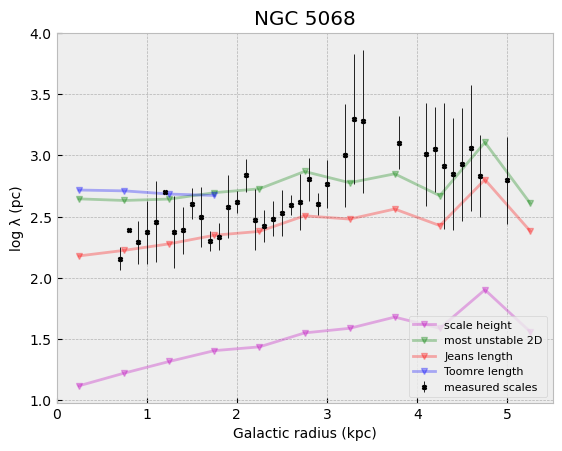

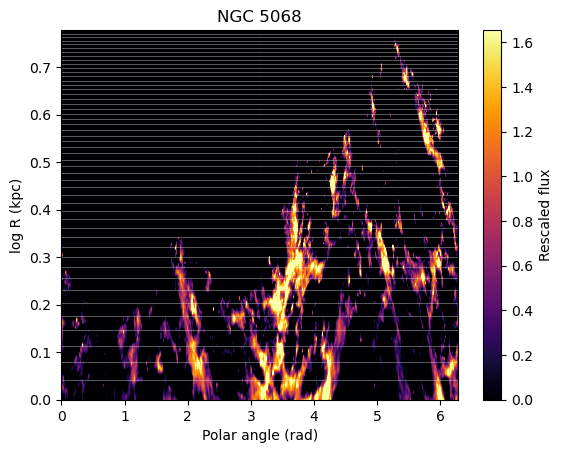

In [67]:
ngc5068 = Galaxy('NGC 5068')
ngc5068.getscales('/mnt/bigdata/PHANGS/Archive/Products/mega_tables/v4p0/annulus/NGC5068_combined_annulus_0p5kpc.ecsv')
ngc5068.readdata('/mnt/space/erosolow/phangs_jwst/v0p8p1_anchored/ngc5068_F770W_atF2100W_anchored.fits', '7.7')
#ngc5068.readdata('/mnt/bigdata/PHANGS/Archive/ALMA/delivery_v4p0/ngc5068/ngc5068_12m+7m+tp_co21_broad_mom0.fits', 'CO')
#ngc5068.readdata('/mnt/bigdata/PHANGS/Archive/MUSE/DR2.2/copt/MUSEDAP/fiducial/NGC5068-1.04asec_MAPS.fits', 'Ha')
#ngc5068.readdata('/mnt/space/erosolow/phangs_jwst/v0p8p1_anchored/ngc5068_F2100W_atF2100W_anchored.fits', '21')
ngc5068.setgeometry('ngc5068', '/mnt/bigdata/PHANGS/Archive/Products/sample_tables/phangs_sample_table_v1p6.fits')
ngc5068.picture_prop(6)
ngc5068.auto_scales('7.7')
ngc5068.show('7.7', 'normalized', 'polar')

Set OBSGEO-B to   -26.453945 from OBSGEO-[XYZ].
Set OBSGEO-H to 1601171718.353 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


shape: 2620x2620


/tmp/ipykernel_4049/3538657962.py:323: RuntimeWarning: Mean of empty slice.
  avg = np.multiply(image_slice, image_shift).mean()
/mnt/home/zjakab/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_4049/3538657962.py:325: RuntimeWarning: Mean of empty slice.
  signl /= (image_slice**2).mean()
/mnt/home/zjakab/anaconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/home/zjakab/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/mnt/home/zjakab/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/

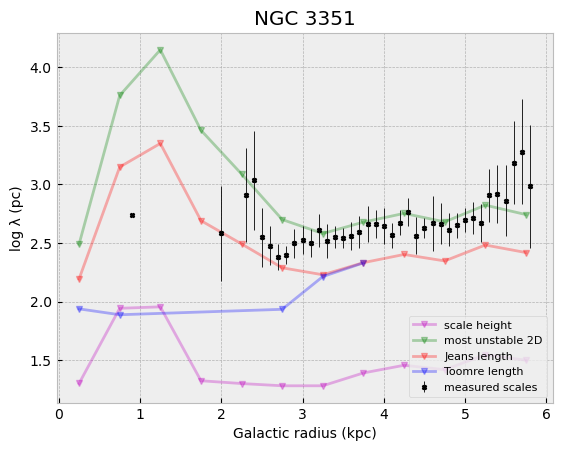

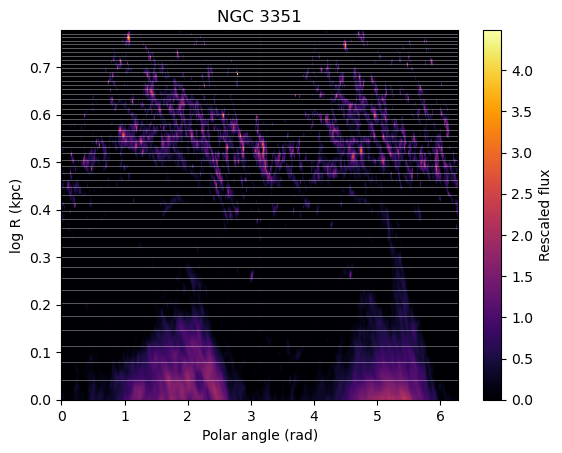

In [68]:
ngc3351 = Galaxy('NGC 3351')
ngc3351.getscales('/mnt/bigdata/PHANGS/Archive/Products/mega_tables/v4p0/annulus/NGC3351_combined_annulus_0p5kpc.ecsv')
ngc3351.readdata('/mnt/space/erosolow/phangs_jwst/v0p8p1_anchored/ngc3351_F770W_atF2100W_anchored.fits', '7.7')
#ngc3351.readdata('/mnt/bigdata/PHANGS/Archive/ALMA/delivery_v4p0/ngc3351/ngc3351_12m+7m+tp_co21_broad_mom0.fits', 'CO')
#ngc3351.readdata('/mnt/bigdata/PHANGS/Archive/MUSE/DR2.2/copt/MUSEDAP/fiducial/NGC3351-1.05asec_MAPS.fits', 'Ha')
#ngc3351.readdata('/mnt/space/erosolow/phangs_jwst/v0p8p1_anchored/ngc3351_F2100W_atF2100W_anchored.fits', '21')
ngc3351.setgeometry('ngc3351', '/mnt/bigdata/PHANGS/Archive/Products/sample_tables/phangs_sample_table_v1p6.fits')
ngc3351.picture_prop(6)
ngc3351.auto_scales('7.7')
ngc3351.show('7.7', 'normalized', 'polar')

Set OBSGEO-B to     8.378158 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674085910.299 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


shape: 2537x2537


/tmp/ipykernel_4049/3538657962.py:323: RuntimeWarning: Mean of empty slice.
  avg = np.multiply(image_slice, image_shift).mean()
/mnt/home/zjakab/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_4049/3538657962.py:325: RuntimeWarning: Mean of empty slice.
  signl /= (image_slice**2).mean()
/mnt/home/zjakab/anaconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/home/zjakab/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/mnt/home/zjakab/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/

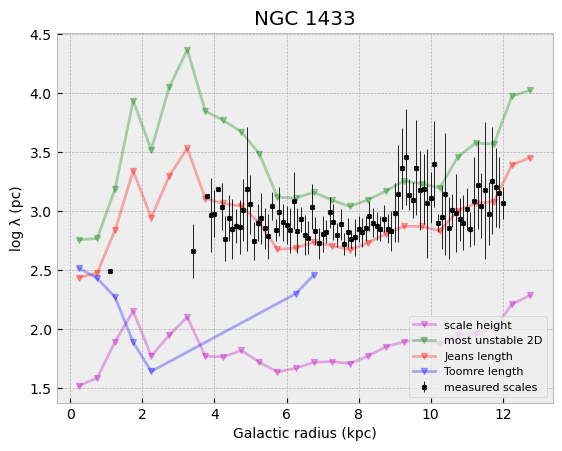

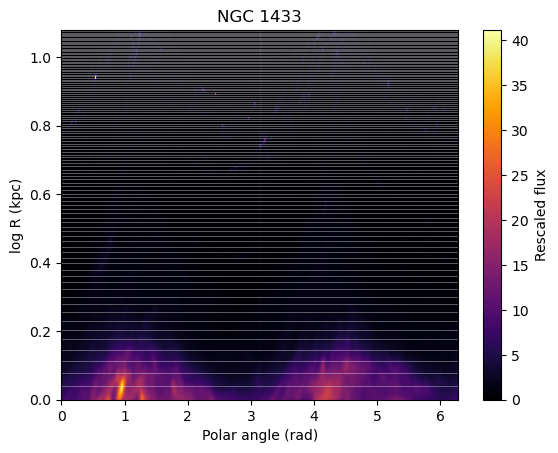

In [69]:
ngc1433 = Galaxy('NGC 1433')
ngc1433.getscales('/mnt/bigdata/PHANGS/Archive/Products/mega_tables/v4p0/annulus/NGC1433_combined_annulus_0p5kpc.ecsv')
ngc1433.readdata('/mnt/space/erosolow/phangs_jwst/v0p8p1_anchored/ngc1433_F770W_atF2100W_anchored.fits', '7.7')
#ngc1433.readdata('/mnt/bigdata/PHANGS/Archive/ALMA/delivery_v4p0/ngc1433/ngc1433_12m+7m+tp_co21_broad_mom0.fits', 'CO')
#ngc1433.readdata('/mnt/bigdata/PHANGS/Archive/MUSE/DR2.2/copt/MUSEDAP/fiducial/NGC1433-0.91asec_MAPS.fits', 'Ha')
#ngc1433.readdata('/mnt/space/erosolow/phangs_jwst/v0p8p1_anchored/ngc1433_F2100W_atF2100W_anchored.fits', '21')
ngc1433.setgeometry('ngc1433', '/mnt/bigdata/PHANGS/Archive/Products/sample_tables/phangs_sample_table_v1p6.fits')
ngc1433.picture_prop(12, tlog=False)
ngc1433.auto_scales('7.7')
ngc1433.show('7.7', 'normalized', 'polar')

Set OBSGEO-B to    12.129948 from OBSGEO-[XYZ].
Set OBSGEO-H to 1626552211.145 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


shape: 2319x2319


/tmp/ipykernel_4049/3538657962.py:323: RuntimeWarning: Mean of empty slice.
  avg = np.multiply(image_slice, image_shift).mean()
/mnt/home/zjakab/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_4049/3538657962.py:325: RuntimeWarning: Mean of empty slice.
  signl /= (image_slice**2).mean()
/mnt/home/zjakab/anaconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/home/zjakab/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/mnt/home/zjakab/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/

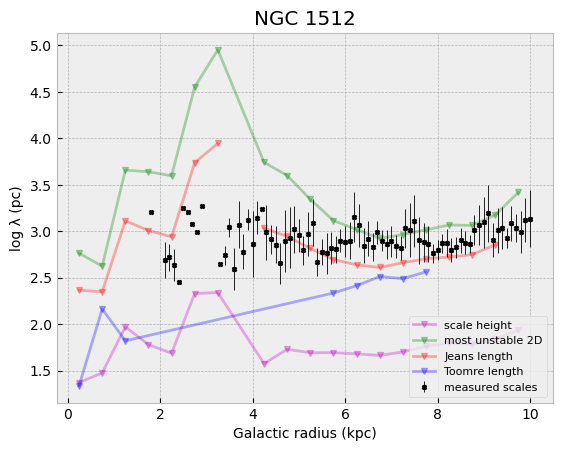

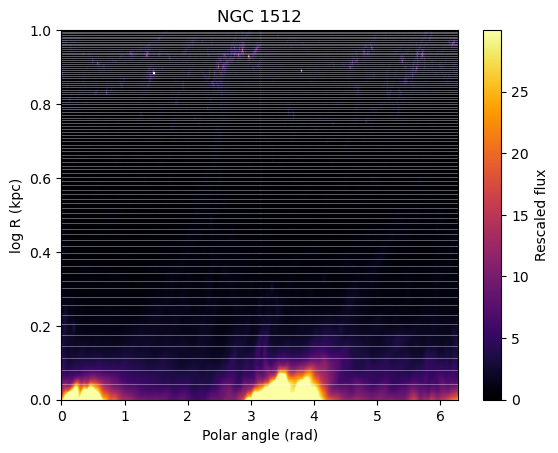

In [70]:
ngc1512 = Galaxy('NGC 1512')
ngc1512.getscales('/mnt/bigdata/PHANGS/Archive/Products/mega_tables/v4p0/annulus/NGC1512_combined_annulus_0p5kpc.ecsv')
ngc1512.readdata('/mnt/space/erosolow/phangs_jwst/v0p8p1_anchored/ngc1512_F770W_atF2100W_anchored.fits', '7.7')
#ngc1512.readdata('/mnt/bigdata/PHANGS/Archive/ALMA/delivery_v4p0/ngc1512/ngc1512_12m+7m+tp_co21_broad_mom0.fits', 'CO')
#ngc1512.readdata('/mnt/bigdata/PHANGS/Archive/MUSE/DR2.2/copt/MUSEDAP/fiducial/NGC1512-1.25asec_MAPS.fits', 'Ha')
#ngc1512.readdata('/mnt/space/erosolow/phangs_jwst/v0p8p1_anchored/ngc1512_F2100W_atF2100W_anchored.fits', '21')
ngc1512.setgeometry('ngc1512', '/mnt/bigdata/PHANGS/Archive/Products/sample_tables/phangs_sample_table_v1p6.fits')
ngc1512.picture_prop(10, tlog=False)
ngc1512.auto_scales('7.7')
ngc1512.show('7.7', 'normalized', 'polar')

/mnt/home/zjakab/project/scale_model.py:64: RuntimeWarning: divide by zero encountered in divide
  lamb2d = (2*self.vdisp[valid_i]**2)/(s.G.value*self.sigma[valid_i])
Set OBSGEO-B to    13.763932 from OBSGEO-[XYZ].
Set OBSGEO-H to 1643933450.077 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


shape: 1551x1551


/tmp/ipykernel_4049/3538657962.py:323: RuntimeWarning: Mean of empty slice.
  avg = np.multiply(image_slice, image_shift).mean()
/mnt/home/zjakab/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_4049/3538657962.py:325: RuntimeWarning: Mean of empty slice.
  signl /= (image_slice**2).mean()
/mnt/home/zjakab/anaconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/home/zjakab/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/mnt/home/zjakab/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/

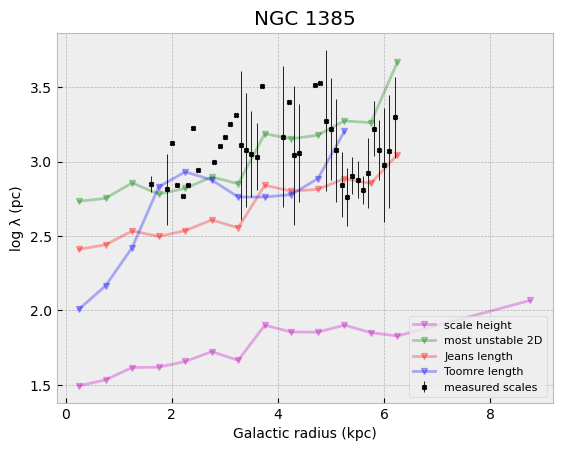

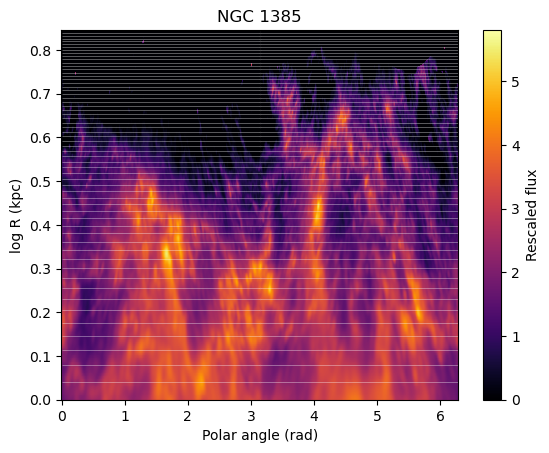

In [71]:
ngc1385 = Galaxy('NGC 1385')
ngc1385.getscales('/mnt/bigdata/PHANGS/Archive/Products/mega_tables/v4p0/annulus/NGC1385_combined_annulus_0p5kpc.ecsv')
ngc1385.readdata('/mnt/space/erosolow/phangs_jwst/v0p8p1_anchored/ngc1385_F770W_atF2100W_anchored.fits', '7.7')
#ngc1385.readdata('/mnt/bigdata/PHANGS/Archive/ALMA/delivery_v4p0/ngc1385/ngc1385_12m+7m+tp_co21_broad_mom0.fits', 'CO')
#ngc1385.readdata('/mnt/bigdata/PHANGS/Archive/MUSE/DR2.2/copt/MUSEDAP/fiducial/NGC1385-0.77asec_MAPS.fits', 'Ha')
#ngc1385.readdata('/mnt/space/erosolow/phangs_jwst/v0p8p1_anchored/ngc1385_F2100W_atF2100W_anchored.fits', '21')
ngc1385.setgeometry('ngc1385', '/mnt/bigdata/PHANGS/Archive/Products/sample_tables/phangs_sample_table_v1p6.fits')
ngc1385.picture_prop(7)
ngc1385.auto_scales('7.7')
ngc1385.show('7.7', 'normalized', 'polar')

Set OBSGEO-B to   -38.354522 from OBSGEO-[XYZ].
Set OBSGEO-H to 1740987127.905 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


shape: 1480x1480


/tmp/ipykernel_4049/3538657962.py:323: RuntimeWarning: Mean of empty slice.
  avg = np.multiply(image_slice, image_shift).mean()
/mnt/home/zjakab/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_4049/3538657962.py:325: RuntimeWarning: Mean of empty slice.
  signl /= (image_slice**2).mean()
/mnt/home/zjakab/anaconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/home/zjakab/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/mnt/home/zjakab/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/

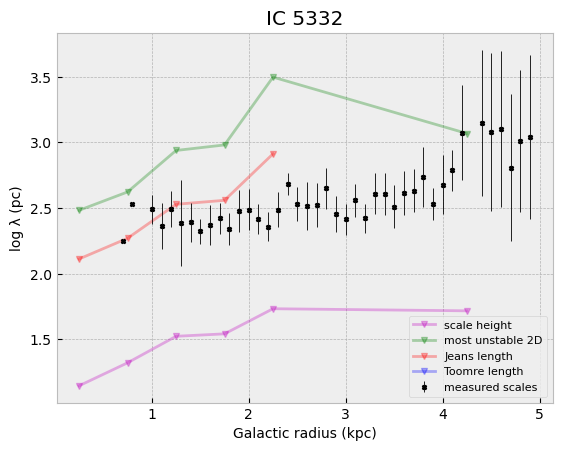

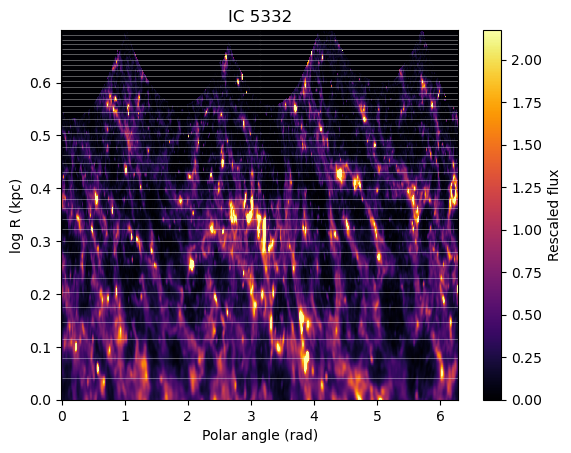

In [72]:
ic5332 = Galaxy('IC 5332')
ic5332.getscales('/mnt/bigdata/PHANGS/Archive/Products/mega_tables/v4p0/annulus/IC5332_combined_annulus_0p5kpc.ecsv')
ic5332.readdata('/mnt/space/erosolow/phangs_jwst/v0p8p1_anchored/ic5332_F770W_atF2100W_anchored.fits', '7.7')
#ic5332.readdata('/mnt/bigdata/PHANGS/Archive/ALMA/delivery_v4p0/ic5332/ic5332_12m+7m+tp_co21_broad_mom0.fits', 'CO')
#ic5332.readdata('/mnt/bigdata/PHANGS/Archive/MUSE/DR2.2/copt/MUSEDAP/fiducial/IC5332-0.87asec_MAPS.fits', 'Ha')
#ic5332.readdata('/mnt/space/erosolow/phangs_jwst/v0p8p1_anchored/ic5332_F2100W_atF2100W_anchored.fits', '21')
ic5332.setgeometry('ic5332', '/mnt/bigdata/PHANGS/Archive/Products/sample_tables/phangs_sample_table_v1p6.fits')
ic5332.picture_prop(5, tlog=False)
ic5332.auto_scales('7.7')
ic5332.show('7.7', 'normalized', 'polar')

Set OBSGEO-B to     9.641306 from OBSGEO-[XYZ].
Set OBSGEO-H to 1660298892.765 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


shape: 2346x2346


/tmp/ipykernel_4049/3538657962.py:323: RuntimeWarning: Mean of empty slice.
  avg = np.multiply(image_slice, image_shift).mean()
/mnt/home/zjakab/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_4049/3538657962.py:325: RuntimeWarning: Mean of empty slice.
  signl /= (image_slice**2).mean()
/mnt/home/zjakab/anaconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/home/zjakab/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/mnt/home/zjakab/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/

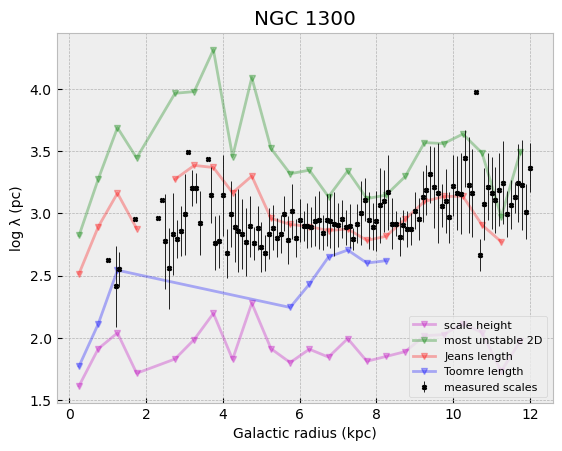

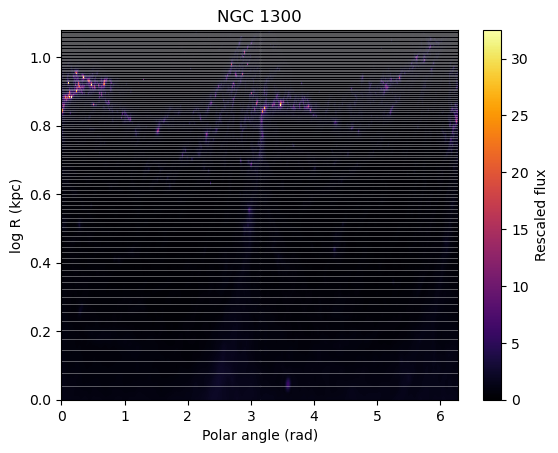

In [73]:
ngc1300 = Galaxy('NGC 1300')
ngc1300.getscales('/mnt/bigdata/PHANGS/Archive/Products/mega_tables/v4p0/annulus/NGC1300_combined_annulus_0p5kpc.ecsv')
ngc1300.readdata('/mnt/space/erosolow/phangs_jwst/v0p8p1_anchored/ngc1300_F770W_atF2100W_anchored.fits', '7.7')
#ngc1300.readdata('/mnt/bigdata/PHANGS/Archive/ALMA/delivery_v4p0/ngc1300/ngc1300_12m+7m+tp_co21_broad_mom0.fits', 'CO')
#ngc1300.readdata('/mnt/bigdata/PHANGS/Archive/MUSE/DR2.2/copt/MUSEDAP/fiducial/NGC1300-0.89asec_MAPS.fits', 'Ha')
#ngc1300.readdata('/mnt/space/erosolow/phangs_jwst/v0p8p1_anchored/ngc1300_F2100W_atF2100W_anchored.fits', '21')
ngc1300.setgeometry('ngc1300', '/mnt/bigdata/PHANGS/Archive/Products/sample_tables/phangs_sample_table_v1p6.fits')
ngc1300.picture_prop(12, tlog=False)
ngc1300.auto_scales('7.7')
ngc1300.show('7.7', 'normalized', 'polar')